In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
data = np.loadtxt('../data/waypoints.txt')

In [4]:
def create_pose(xp, yp, theta):
    
    ct = np.cos(theta)
    st = np.sin(theta)
    
    pose = np.array([[ct, -st, xp], [st, ct, yp], [0, 0, 1]])
    
    return pose


def invert_pose(pose):
    return np.linalg.inv(pose)


def invert_pose_analytical(pose):
    
    ct = pose[0, 0]
    st = pose[1, 0]
    
    xp = pose[0, 2]
    yp = pose[1, 2]
    
    pose_inv = np.array([[ct, st, -(xp*ct + yp*st)], [-st, ct, xp*st - yp*ct], [0, 0, 1]])
    
    return pose_inv


def transform_points(points, pose):
    
    res = []
    
    for i in range(len(points)):
        
        pt = points[i, :]
        pt_h = np.array([pt[0], pt[1], 1])
        pt_t = np.dot(pose, pt_h)
        
        transformed = np.array([pt_t[0] / pt_t[2], pt_t[1] / pt_t[2]])
        
        res.append(transformed)
        
    return np.array(res)
    
    
def dist(x1, x2):
    return np.linalg.norm(x1 - x2)


def find_closest_index(points_c):
    
    origin = np.array([0, 0])
    distances = np.array([dist(p, origin) for p in points_c])
    
    closest_idx = distances.argmin()
    
    return closest_idx, distances[closest_idx]


def get_next_points(points_c, start_idx, n_points):
    
    n = len(points_c)
    
    xs = []
    ys = []
    count = 0
    idx = start_idx
    
    while count < n_points:
        
        x = points_c[idx, 0]
        y = points_c[idx, 1]
        
        xs.append(x)
        ys.append(y)
        
        count += 1
        idx += 1
        if idx == n:
            idx = 0
            
    return np.array(xs), np.array(ys)


def polyfit_n(points_c, start_idx, dim, n_points):
        
    xs, ys = get_next_points(points_c, start_idx, n_points)
    return np.polyfit(xs, ys, dim)  
        

def plot_poly(coefs, x0, x1):
    
    poly = np.poly1d(coefs)
    
    x = np.linspace(x0, x1)
    y = poly(x)

    plt.plot(x, y)
    

def closest_line(points_c, closest_idx, closest_dist):
    
    if closest_dist > 0:
        
        p1 = points_c[closest_idx - 1, :]
        p2 = points_c[closest_idx, :]
        
    else:
        
        p1 = points_c[closest_idx, :]
        p2 = points_c[closest_idx + 1, :]
        
    x1, y1 = p1
    x2, y2 = p2
        
    slope = (y2 - y1) / (x2 - x1)
    intercept = y2 - slope * x2
    
    return slope, intercept, p1, p2


def measure_errors(slope, intercept):
    
    x0, y0 = 0, 0
    
    epsi = math.atan(slope)
    cte = abs(intercept + slope * x0 - y0) / math.sqrt(1 + slope**2)
    
    return cte, epsi

In [5]:
car_x = -40.62
car_y = 108.73
car_psi = 3.733651

car_pose_in_map = create_pose(car_x, car_y, car_psi) 
t_map_to_car = invert_pose(car_pose_in_map)
points_c = transform_points(data, t_map_to_car)

In [6]:
closest_idx, closest_dist = find_closest_index(points_c)
print('Closest index:', closest_idx)
print('Distance to the closest waypoint:', closest_dist)

Closest index: 18
Distance to the closest waypoint: 4.003168019568989


slope:		-0.012247857457099422
intercept:	0.7599170008006434


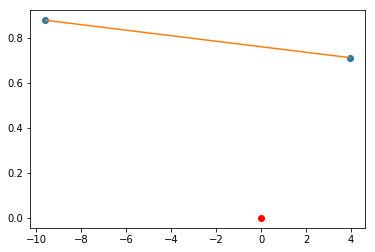

In [7]:
slope, intercept, p1, p2 = closest_line(points_c, closest_idx, closest_dist)

plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'o')
plt.plot(0, 0, 'ro')

plot_poly([slope, intercept], p1[0], p2[0])


print('slope:\t\t{}\nintercept:\t{}'.format(slope, intercept))

Coefficients: [3.45967402e-06 5.64983981e-04 3.86075853e-02 4.39057095e-01]
cte:	0.7598600096331829
epsi:	-0.012247245078467013


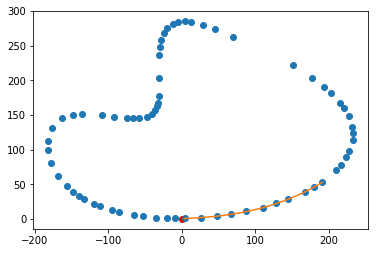

In [8]:
def plot_waypoints_and_poly(start_idx):
    
    N_POINTS = 10
    n = len(points_c)
    
    plt.plot(points_c[:, 0], points_c[:, 1], 'o')

    coefs = polyfit_n(points_c, start_idx, dim=3, n_points=N_POINTS)
    print('Coefficients:', coefs)
    
    x0 = points_c[start_idx, 0]
    
    end_idx = start_idx+N_POINTS
    if end_idx >= n:
        end_idx -= n
    
    x1 = points_c[end_idx, 0]
    
    plot_poly(coefs, x0, x1)

start_idx = closest_idx
if closest_dist < 0:
    start_idx += 1
    
plt.plot(0, 0, 'ro')

plot_waypoints_and_poly(start_idx)

cte, epsi = measure_errors(slope, intercept)
print('cte:\t{}\nepsi:\t{}'.format(cte, epsi))

In [9]:
get_next_points(points_c, start_idx, 5)

(array([ 3.93940137, 25.82850578, 48.00129425, 67.72019922, 88.17418855]),
 array([ 0.71166777,  1.72439291,  3.86950111,  6.7442717 , 10.77765711]))

In [10]:
print('Index:\tDistance to origin\tx coordinate')
for i, p in enumerate(points_c):
    print( '{}:\t{:.3f}\t\t\t{:.3f}'.format(i, dist(p, [0, 0]), p[0]) )

Index:	Distance to origin	x coordinate
0:	220.158			-176.882
1:	213.096			-181.403
2:	207.027			-181.456
3:	194.953			-177.284
4:	179.102			-167.928
5:	162.639			-155.700
6:	152.821			-147.652
7:	143.866			-139.881
8:	135.552			-132.453
9:	121.108			-119.125
10:	112.054			-110.582
11:	95.851			-95.005
12:	86.192			-85.601
13:	64.659			-64.425
14:	53.365			-53.233
15:	35.705			-35.656
16:	19.534			-19.521
17:	9.643			-9.603
18:	4.003			3.939
19:	25.886			25.829
20:	48.157			48.001
21:	68.055			67.720
22:	88.830			88.174
23:	111.938			110.739
24:	130.617			128.699
25:	147.706			144.968
26:	172.553			168.090
27:	186.003			180.164
28:	198.851			191.395
29:	221.147			209.723
30:	230.281			216.703
31:	241.490			224.336
32:	248.560			228.240
33:	258.739			232.588
34:	264.070			232.900
35:	267.698			232.191
36:	271.603			227.518
37:	272.937			221.036
38:	273.415			216.123
39:	272.824			203.836
40:	271.875			193.931
41:	269.914			177.068
42:	267.835			150.929
43:	271.460			70.466
44:	277.884			